<a href="https://colab.research.google.com/github/chiragpipalia/Classification-Eval-Metrics/blob/main/KS_AUC_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.naive_bayes import GaussianNB
import plotly.express as px

sns.set_context("paper")

In [2]:
size = 5000
scale = 5
def create_dataset(size = 5000, scale = 5):

  # Generate two classes out of normal distributions - good classifier
  class1_x = np.random.normal(loc = 10, scale = scale, size = size)
  class1_y = np.random.normal(loc = 1, scale = scale, size = size)

  class2_x = np.random.normal(loc = 1, scale = scale, size = size)
  class2_y = np.random.normal(loc = 5, scale = scale, size = size)

  df_class1 = pd.DataFrame({'x' : class1_x, 'y' : class1_y, 'class': 0})
  df_class2 = pd.DataFrame({'x' : class2_x, 'y' : class2_y, 'class': 1})
  df = pd.concat([df_class1, df_class2])
  return df

<Axes: xlabel='x', ylabel='y'>

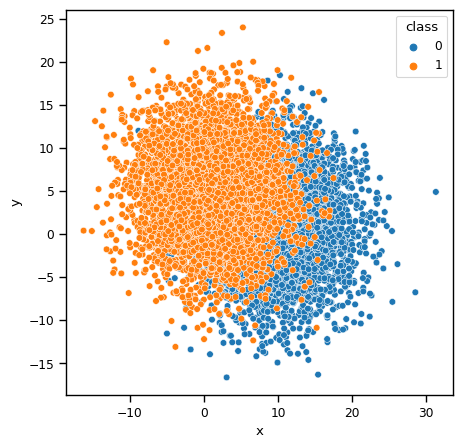

In [3]:
df_med = create_dataset(scale = 5)
# Plot both to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(data = df_med, x = 'x', y = 'y', hue = 'class')

<Axes: xlabel='x', ylabel='y'>

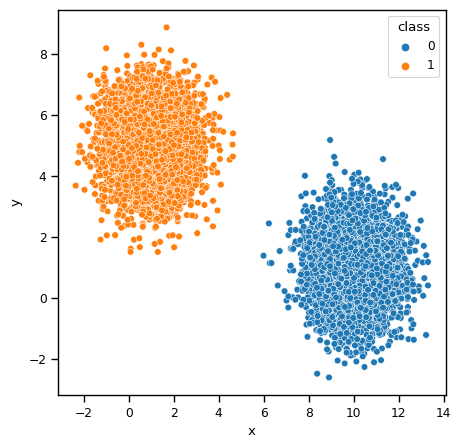

In [9]:
df_good = create_dataset(scale = 1)
plt.figure(figsize=(5, 5))
sns.scatterplot(data = df_good, x = 'x', y = 'y', hue = 'class')

<Axes: xlabel='x', ylabel='y'>

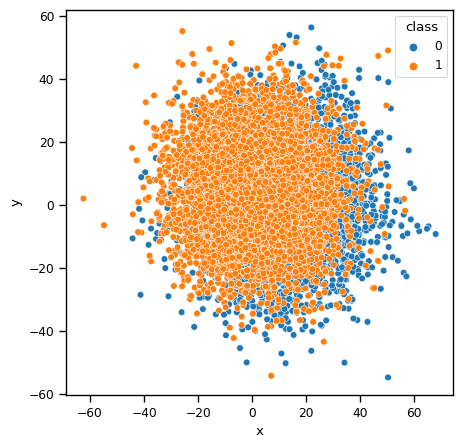

In [10]:
df_bad = create_dataset(scale = 15)
plt.figure(figsize=(5, 5))
sns.scatterplot(data = df_bad, x = 'x', y = 'y', hue = 'class')

In [11]:
def get_train_test_split(df):
  X = df[['x', 'y']].values
  y = df[['class']].values
  train_samples = 1000  # Samples used for training the models
  X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      shuffle=True
  )
  return X_train, X_test, y_train, y_test

def train_model_return_probs(df):
  X_train, X_test, y_train, y_test = get_train_test_split(df)
  model_good = GaussianNB()
  model_good.fit(X_train, y_train)
  y_pred_good = model_good.predict(X_test)
  y_proba_good = model_good.predict_proba(X_test)

  return y_proba_good, y_test

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



<Axes: ylabel='Count'>

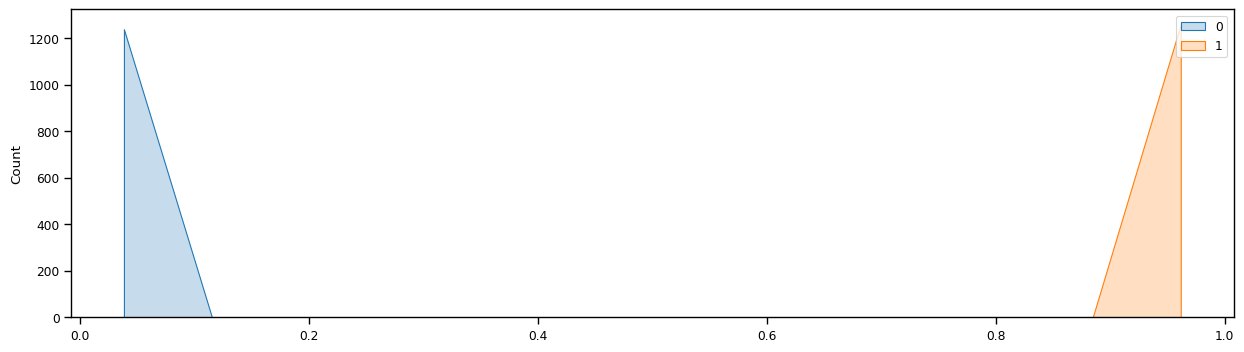

In [12]:
y_proba_good, y_test_good = train_model_return_probs(df_good)
fig = plt.figure(figsize = (15, 4))
sns.histplot(x = y_proba_good[:, 1], hue = y_test_good.flatten(), element="poly")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



<Axes: ylabel='Count'>

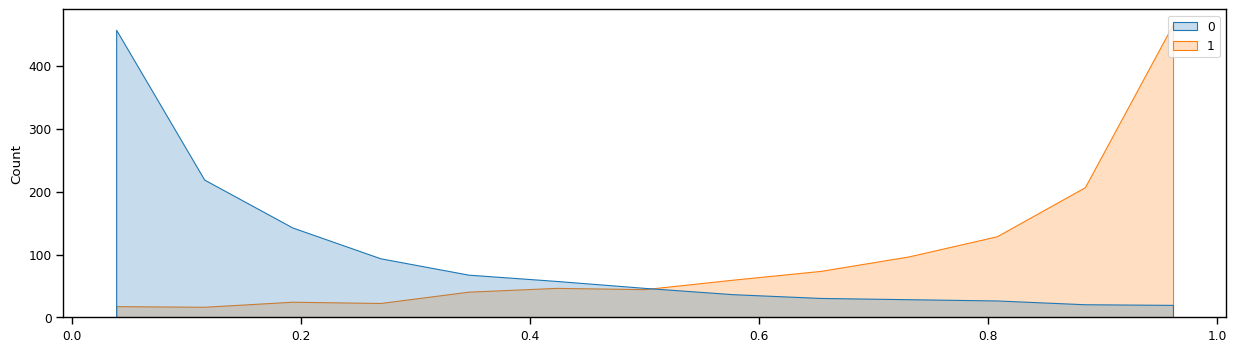

In [13]:
y_proba_med, y_test_med = train_model_return_probs(df_med)
fig = plt.figure(figsize = (15, 4))
sns.histplot(x = y_proba_med[:, 1], hue = y_test_med.flatten(), element="poly")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



<Axes: ylabel='Count'>

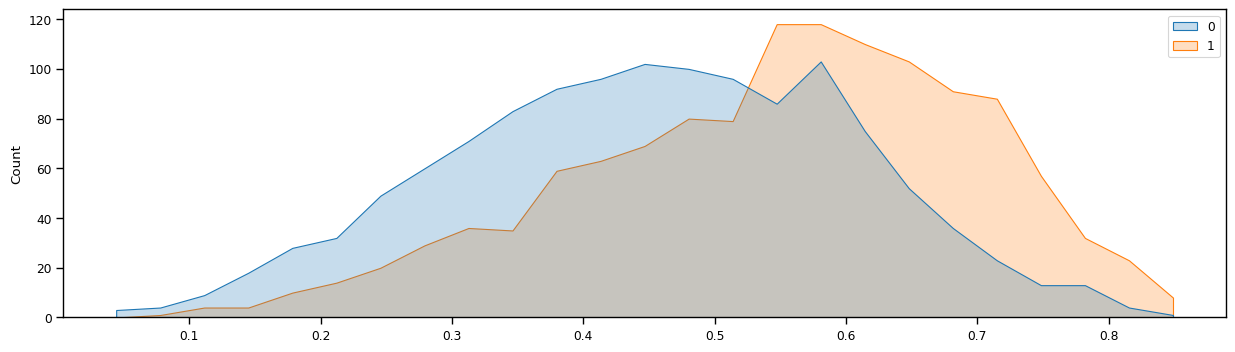

In [14]:
y_proba_bad, y_test_bad = train_model_return_probs(df_bad)
fig = plt.figure(figsize = (15, 4))
sns.histplot(x = y_proba_bad[:, 1], hue = y_test_bad.flatten(), element="poly")

<Axes: ylabel='Count'>

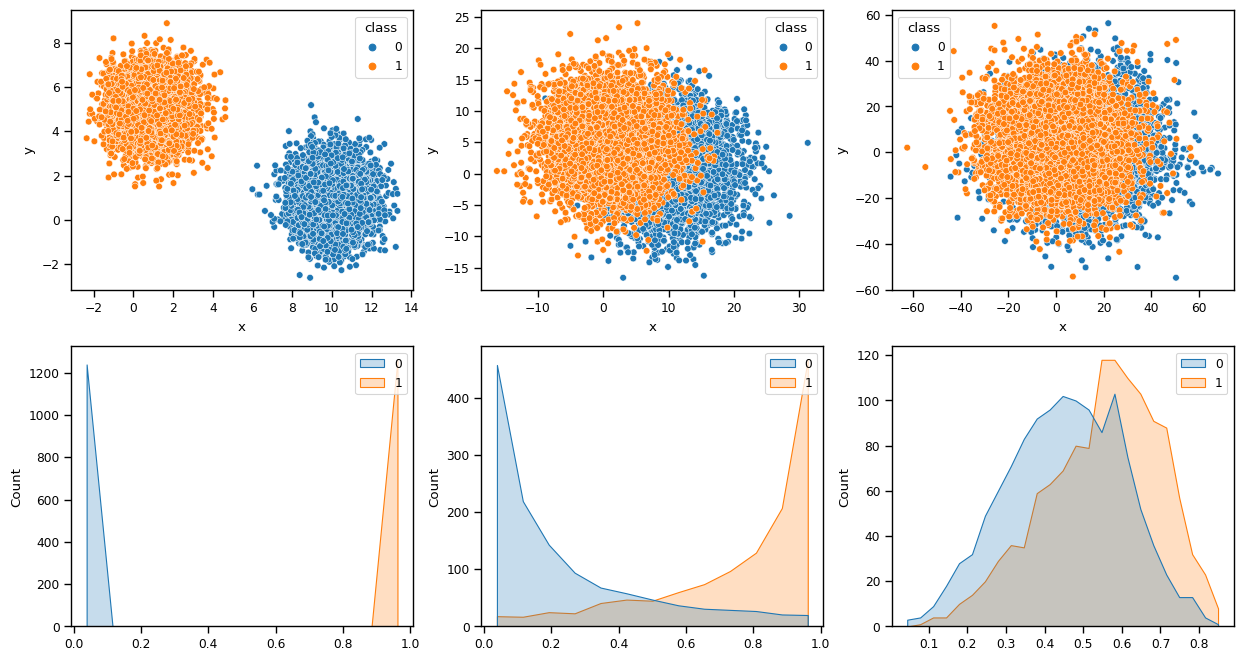

In [26]:
f, axes = plt.subplots(2, 3, figsize=(15,8))

sns.scatterplot(data = df_good, x = 'x', y = 'y', hue = 'class', ax=axes[0, 0])
sns.scatterplot(data = df_med, x = 'x', y = 'y', hue = 'class', ax=axes[0, 1])
sns.scatterplot(data = df_bad, x = 'x', y = 'y', hue = 'class', ax=axes[0, 2])

sns.histplot(x = y_proba_good[:, 1], hue = y_test_good.flatten(), element="poly", ax=axes[1, 0])
sns.histplot(x = y_proba_med[:, 1], hue = y_test_med.flatten(), element="poly", ax=axes[1, 1])
sns.histplot(x = y_proba_bad[:, 1], hue = y_test_bad.flatten(), element="poly", ax=axes[1, 2])

In [28]:
def cdf(sample, x, sort = False):
    '''
    Return the value of the Cumulative Distribution Function, evaluated for a given sample and a value x.

    Args:
        sample: The list or array of observations.
        x: The value for which the numerical cdf is evaluated.

    Returns:
        cdf = CDF_{sample}(x)
    '''

    # Sorts the sample, if needed
    if sort:
        sample.sort()

    # Counts how many observations are below x
    cdf = sum(sample <= x)

    # Divides by the total number of observations
    cdf = cdf / len(sample)

    return cdf

# Gets the class CDFs
def get_classes_cdf(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba[:, 1]

    # Recover each class
    class0 = df[df['real'] == 0].sort_values('proba', ascending = False)
    class1 = df[df['real'] == 1].sort_values('proba', ascending = False)

    # Calculates the cdfs
    cdf0 = np.array([cdf(class0['proba'].values, x, sort = False) for x in class0['proba'].values])
    cdf1 = np.array([cdf(class1['proba'].values, x, sort = False) for x in class1['proba'].values])

    # Results
    results =  {
        'cdf0': cdf0,
        'cdf1': cdf1,
        'proba0': class0['proba'].values,
        'proba1': class1['proba'].values,
    }

    return results

In [29]:
cdf_good = get_classes_cdf(y_test_good.flatten(), y_proba_good)
cdf_med = get_classes_cdf(y_test_med.flatten(), y_proba_med)
cdf_bad = get_classes_cdf(y_test_bad.flatten(), y_proba_bad)

Text(0, 0.5, 'Cumulative Capture')

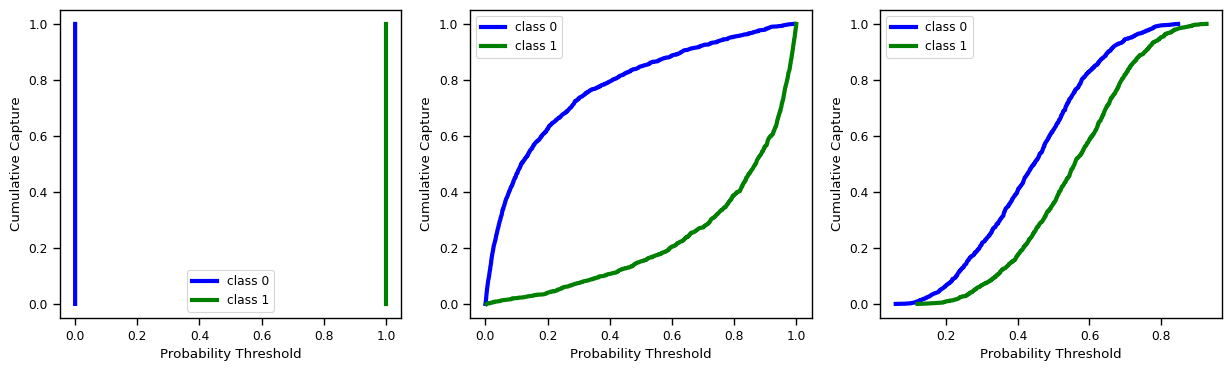

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.lineplot(x = cdf_good['proba0'], y = cdf_good['cdf0'], color = 'b', linewidth = 3,  ax = axes[0], label='class 0')
sns.lineplot(x = cdf_good['proba1'], y = cdf_good['cdf1'], color = 'g', linewidth = 3,  ax = axes[0], label='class 1')
# ax1.legend(["class 0", "class 1"])

sns.lineplot(x = cdf_med['proba0'], y = cdf_med['cdf0'], color = 'b', linewidth = 3,  ax = axes[1], label='class 0')
sns.lineplot(x = cdf_med['proba1'], y = cdf_med['cdf1'], color = 'g', linewidth = 3,  ax = axes[1], label='class 1')

sns.lineplot(x = cdf_bad['proba0'], y = cdf_bad['cdf0'], color = 'b', linewidth = 3,  ax = axes[2], label='class 0')
sns.lineplot(x = cdf_bad['proba1'], y = cdf_bad['cdf1'], color = 'g', linewidth = 3,  ax = axes[2], label='class 1')

axes[0].set_xlabel("Probability Threshold")
axes[0].set_ylabel("Cumulative Capture")

axes[1].set_xlabel("Probability Threshold")
axes[1].set_ylabel("Cumulative Capture")

axes[2].set_xlabel("Probability Threshold")
axes[2].set_ylabel("Cumulative Capture")


## AUC-ROC

In [40]:
## AUC Curve
def get_fpr_tpr(y_test, y_proba):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
  return fpr, tpr


In [41]:
fpr_good, tpr_good = get_fpr_tpr(y_test_good.ravel(), y_proba_good[:,1])
fpr_med, tpr_med = get_fpr_tpr(y_test_med.ravel(), y_proba_med[:,1])
fpr_bad, tpr_bad = get_fpr_tpr(y_test_bad.ravel(), y_proba_bad[:,1])


Text(0, 0.5, 'TPR')

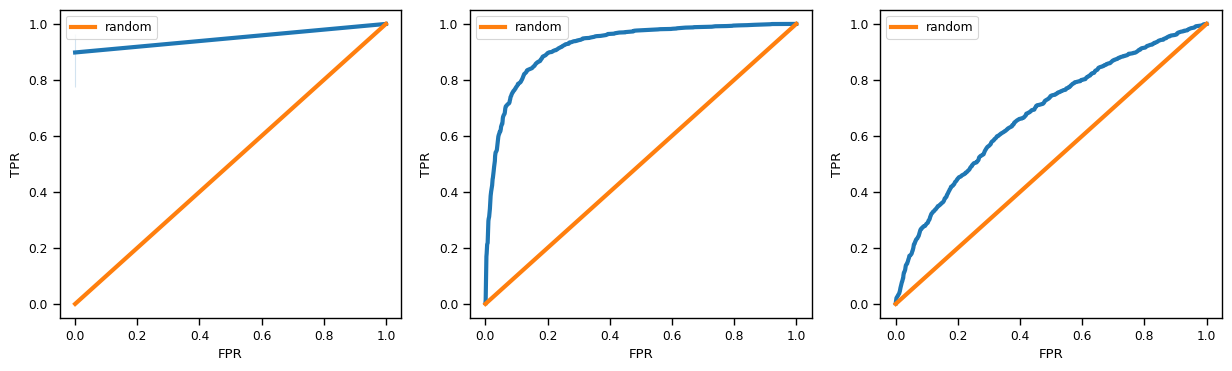

In [42]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.lineplot(x = fpr_good, y = tpr_good, linewidth = 3,  ax = axes[0])
sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[0], label="random")
sns.lineplot(x = fpr_med, y = tpr_med, linewidth = 3,  ax = axes[1])
sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[1], label="random")
sns.lineplot(x = fpr_bad, y = tpr_bad, linewidth = 3,  ax = axes[2])
sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[2], label="random")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[2].set_xlabel("FPR")
axes[2].set_ylabel("TPR")



In [43]:
auc_good = metrics.roc_auc_score(y_test_good.ravel(), y_proba_good[:,1])
auc_med = metrics.roc_auc_score(y_test_med.ravel(), y_proba_med[:,1])
auc_bad = metrics.roc_auc_score(y_test_bad.ravel(), y_proba_bad[:,1])

print(f"{auc_good=}, {auc_med=}, {auc_bad=}")

auc_good=1.0, auc_med=0.9214373897199295, auc_bad=0.677910193862524


## PR Curve

In [ ]:
def get_pr(y_test, y_proba):
  """
  CM = [[TN, FP]
        [FN, TP]]
  Precision = TP/(FP + TP)
  Recall = TP/(FN + TP)
  """

In [44]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [45]:
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test_med.ravel(), y_proba_med[:,1])
auc_score = auc(recall, precision)
print('Naive Bayes PR AUC: %.3f' % auc_score)

Naive Bayes PR AUC: 0.915


In [46]:
precision_good, recall_good, _ = precision_recall_curve(y_test_good.ravel(), y_proba_good[:,1])
precision_med, recall_med, _ = precision_recall_curve(y_test_med.ravel(), y_proba_med[:,1])
precision_bad, recall_bad, _ = precision_recall_curve(y_test_bad.ravel(), y_proba_bad[:,1])

Text(0, 0.5, 'Precision')

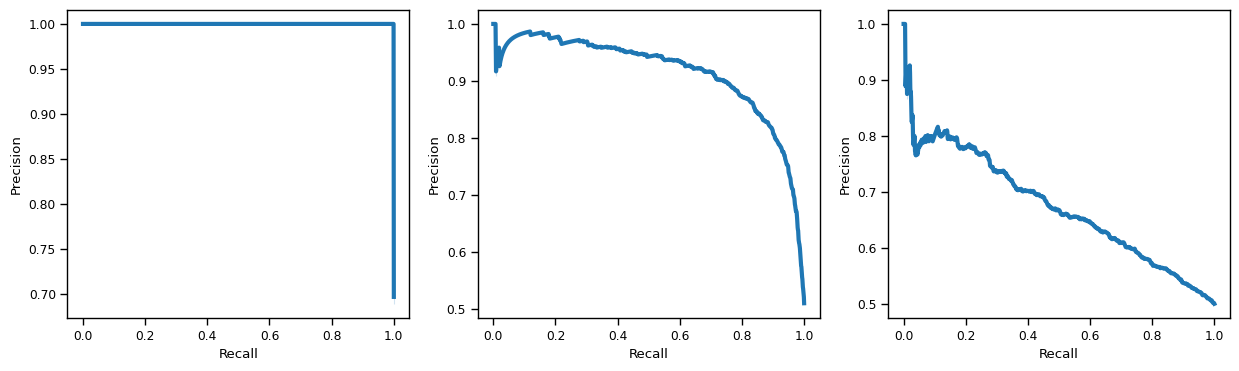

In [47]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.lineplot(x = recall_good, y = precision_good, linewidth = 3,  ax = axes[0])
# sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[0], label="random")
sns.lineplot(x = recall_med, y = precision_med, linewidth = 3,  ax = axes[1])
# sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[1], label="random")
sns.lineplot(x = recall_bad, y = precision_bad, linewidth = 3,  ax = axes[2])
# sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[2], label="random")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")

In [48]:
pr_auc_good = auc(recall_good, precision_good)
pr_auc_med = auc(recall_med, precision_med)
pr_auc_bad = auc(recall_bad, precision_bad)
print(f"{pr_auc_good=:.4f}, {pr_auc_med=:.4f}, {pr_auc_bad=:.4f}")

pr_auc_good=1.0000, pr_auc_med=0.9149, pr_auc_bad=0.6745


## Imbalance Data

In [36]:
def create_imbalance_dataset(df):
  df_class1 = df.loc[df["class"] == 1][:int(0.05*df.shape[0])]
  df_class0 = df.loc[df["class"] == 0][:int(0.95*df.shape[0])]

  df_imb = pd.concat([df_class0, df_class1], ignore_index = True)
  return df_imb

In [37]:
df_imb_good = create_imbalance_dataset(df_good)
df_imb_med = create_imbalance_dataset(df_med)
df_imb_bad = create_imbalance_dataset(df_bad)

In [38]:
y_proba_imb_good, y_test_imb_good = train_model_return_probs(df_imb_good)
y_proba_imb_med, y_test_imb_med = train_model_return_probs(df_imb_med)
y_proba_imb_bad, y_test_imb_bad = train_model_return_probs(df_imb_bad)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [49]:
fpr_imb_good, tpr_imb_good = get_fpr_tpr(y_test_imb_good.ravel(), y_proba_imb_good[:,1])
fpr_imb_med, tpr_imb_med = get_fpr_tpr(y_test_imb_med.ravel(), y_proba_imb_med[:,1])
fpr_imb_bad, tpr_imb_bad = get_fpr_tpr(y_test_imb_bad.ravel(), y_proba_imb_bad[:,1])

Text(0, 0.5, 'TPR')

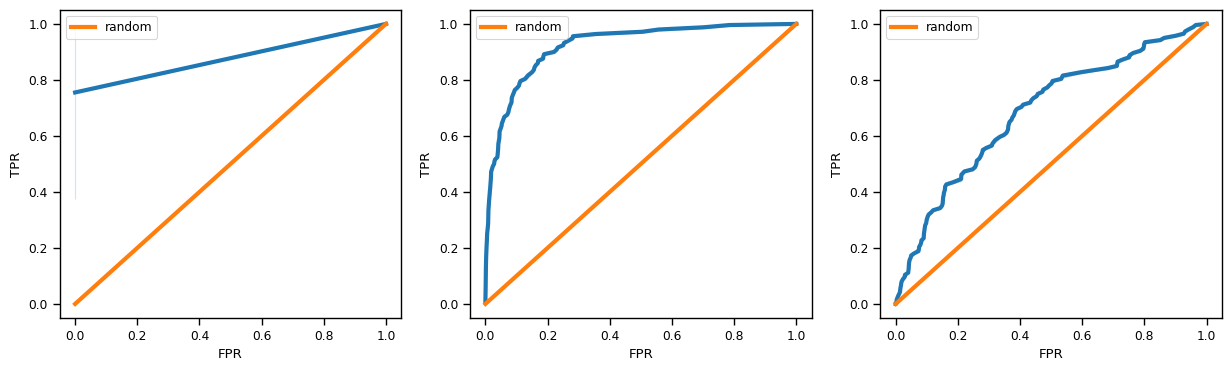

In [50]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.lineplot(x = fpr_imb_good, y = tpr_imb_good, linewidth = 3,  ax = axes[0])
sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[0], label="random")
sns.lineplot(x = fpr_imb_med, y = tpr_imb_med, linewidth = 3,  ax = axes[1])
sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[1], label="random")
sns.lineplot(x = fpr_imb_bad, y = tpr_imb_bad, linewidth = 3,  ax = axes[2])
sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[2], label="random")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[2].set_xlabel("FPR")
axes[2].set_ylabel("TPR")

In [51]:
auc_good_imb = metrics.roc_auc_score(y_test_imb_good.ravel(), y_proba_imb_good[:,1])
auc_med_imb = metrics.roc_auc_score(y_test_imb_med.ravel(), y_proba_imb_med[:,1])
auc_bad_imb = metrics.roc_auc_score(y_test_imb_bad.ravel(), y_proba_imb_bad[:,1])

print(f"{auc_good_imb=:.4f}, {auc_med_imb=:.4f}, {auc_bad_imb=:.4f}")

auc_good_imb=1.0000, auc_med_imb=0.9225, auc_bad_imb=0.6853


### PR

In [52]:
precision_imb_good, recall_imb_good, _ = precision_recall_curve(y_test_imb_good.ravel(), y_proba_imb_good[:,1])
precision_imb_med, recall_imb_med, _ = precision_recall_curve(y_test_imb_med.ravel(), y_proba_imb_med[:,1])
precision_imb_bad, recall_imb_bad, _ = precision_recall_curve(y_test_imb_bad.ravel(), y_proba_imb_bad[:,1])

In [53]:
pr_auc_imb_good = auc(recall_imb_good, precision_imb_good)
pr_auc_imb_med = auc(recall_imb_med, precision_imb_med)
pr_auc_imb_bad = auc(recall_imb_bad, precision_imb_bad)
print(f"{pr_auc_imb_good=:.4f}, {pr_auc_imb_med=:.4f}, {pr_auc_imb_bad=:.4f}")

pr_auc_imb_good=1.0000, pr_auc_imb_med=0.6204, pr_auc_imb_bad=0.1837


Text(0, 0.5, 'Precision')

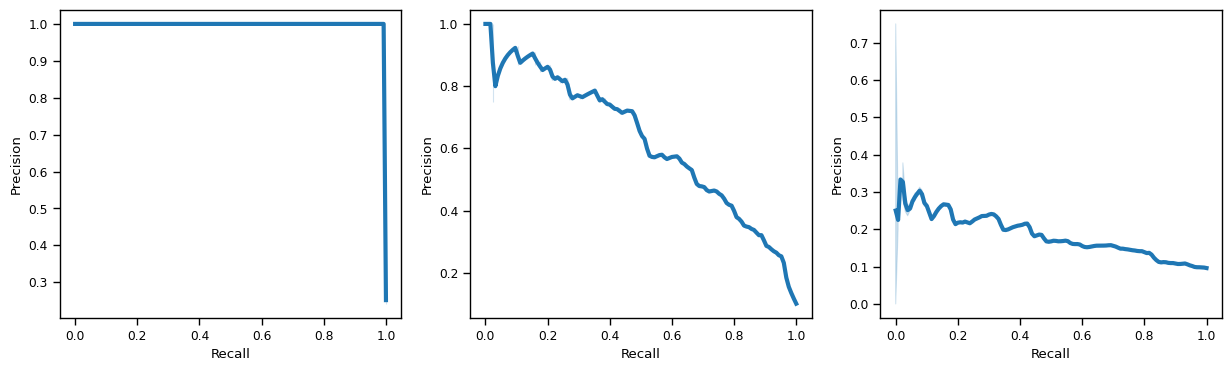

In [54]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.lineplot(x = recall_imb_good, y = precision_imb_good, linewidth = 3,  ax = axes[0])
# sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[0], label="random")
sns.lineplot(x = recall_imb_med, y = precision_imb_med, linewidth = 3,  ax = axes[1])
# sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[1], label="random")
sns.lineplot(x = recall_imb_bad, y = precision_imb_bad, linewidth = 3,  ax = axes[2])
# sns.lineplot(x = [0, 0.5 ,1], y = [0, 0.5, 1], dashes=True, linewidth = 3,  ax = axes[2], label="random")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")

array([0, 1, 0, ..., 0, 0, 1])

array([1.16000001e-16, 1.00000000e+00, 1.33431643e-26, ...,
       2.71500036e-17, 4.49289737e-13, 1.00000000e+00])

In [64]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.4}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.4}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.4}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.4}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    #print(kstable)

    #Display KS

    #print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return kstable


df_res = pd.DataFrame({'y_test':y_test_med.ravel(), 'y_preds':y_proba_med[:, 1]})
mydf = ks(data=df_res, target="y_test", prob="y_preds")
mydf

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.971667,0.999855,244,6,0.1954,0.004796,0.1954,0.004796,19.1
2,0.920943,0.971603,235,15,0.1882,0.01199,0.3835,0.01679,36.7
3,0.828983,0.920920,224,26,0.1793,0.02078,0.5629,0.03757,52.5
4,0.689306,0.828692,199,51,0.1593,0.04077,0.7222,0.07834,64.4
5,0.490119,0.688537,156,94,0.1249,0.07514,0.8471,0.1535,69.4
6,0.310443,0.488658,106,144,0.08487,0.1151,0.9319,0.2686,66.3
7,0.170466,0.309988,47,203,0.03763,0.1623,0.9696,0.4309,53.9
8,0.083864,0.169705,18,232,0.01441,0.1855,0.984,0.6163,36.8
9,0.031350,0.083631,13,237,0.01041,0.1894,0.9944,0.8058,18.9
